In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
import numpy as np
from math import ceil
SEED = 25


In [2]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df['class'] = round(df['class'] / 10).astype(int)
df = df[df['class'] != 1]
_type = df['type'].to_list()
df = df.drop(['name', 'side_mistake',
              'vs', 'squared_vs', 'ttr', 'root_ttr',
              'log_ttr', 'uber_ttr', 'd', 'vvi',
              'squared_vv', 'punct_mistakes_pp',
              'punct_mistakes_because',
              'punct_mistakes_but', 'punct_mistakes_compare'], axis=1)

df.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,5,1,0,0,2,0,This two line graphs illustrates monthly avera...,6,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,6,1,0,0,3,0,"﻿We have two graphics, which show us the popul...",6,1,0


In [3]:
df.shape

(3440, 62)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440 entries, 0 to 3440
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   av_depth               3440 non-null   float64
 1   max_depth              3440 non-null   int64  
 2   min_depth              3440 non-null   int64  
 3   num_acl                3440 non-null   int64  
 4   num_rel_cl             3440 non-null   int64  
 5   num_advcl              3440 non-null   int64  
 6   num_sent               3440 non-null   int64  
 7   num_tok                3440 non-null   int64  
 8   av_tok_before_root     3440 non-null   float64
 9   av_len_sent            3440 non-null   float64
 10  num_cl                 3440 non-null   int64  
 11  num_tu                 3440 non-null   int64  
 12  num_compl_tu           3440 non-null   int64  
 13  num_coord              3440 non-null   int64  
 14  num_poss               3440 non-null   int64  
 15  num_

In [5]:
df['class'].value_counts()

6    2680
7     308
5     215
4     122
8      77
2      24
3      14
Name: class, dtype: int64

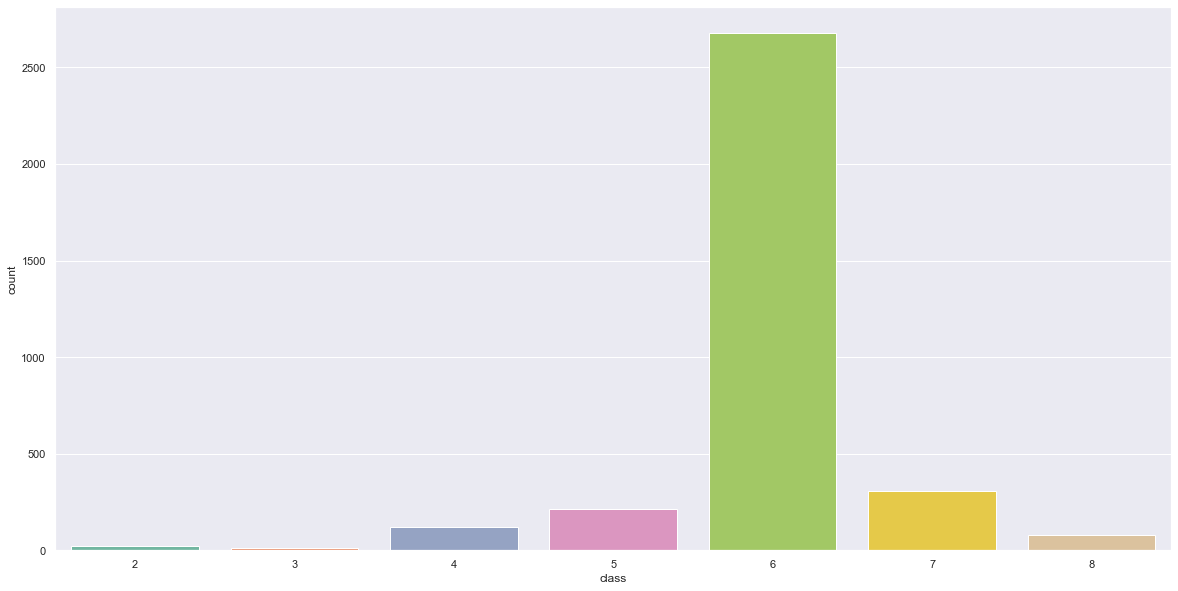

In [6]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='class', data=df, palette="Set2")

In [7]:
feature_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X = df[feature_columns]
y = df['class'] - 2
y.loc[y == 1] = 3
y.loc[y == 0] = 3
y.loc[y == 2] = 3
y.loc[y == 5] = 6

y.loc[y == 3] = 0
y.loc[y == 4] = 1
y.loc[y == 6] = 2

In [8]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

Так как количество элементов в классах не равномерно то объединим классы 2,3,4,5; 7, 8; и уберем часть элементов из 6 класса

In [9]:

train_y.value_counts()

1    2139
2     322
0     291
Name: class, dtype: int64

In [10]:
dummy = train_y.loc[train_y == 1][:315]
train_y.drop(train_y.loc[train_y == 1].index, inplace=True)
train_y = pd.concat([train_y, dummy], ignore_index=True)
train_y.value_counts()

2    322
1    315
0    291
Name: class, dtype: int64

In [11]:
y_idx = train_y.index
train_x = train_x.iloc[y_idx.to_list()]
train_x.reset_index(inplace=True, drop=True)
test_x.reset_index(inplace=True, drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

In [12]:
train_y2 = []
for y in train_y:
    y2 = np.zeros(3)
    y2[y] = 1
    train_y2.append(y2)
    
test_y2 = []
for y in test_y:
    y2 = np.zeros(3)
    y2[y] = 1
    test_y2.append(y2)
    
train_y2 = np.array(train_y2)
test_y2 = np.array(test_y2)

In [13]:
from sklearn.metrics import make_scorer, accuracy_score
def custom_scorer(y_true, y_pred):
    y_true = [np.argmax(y) for y in y_true]
    y_true = np.array(y_true)
    return accuracy_score(y_true, y_pred)
scorer = make_scorer(custom_scorer, greater_is_better=True)

In [14]:
train_x2 = np.array(train_x)
test_x2 = np.array(test_x)

In [15]:
train_x3 = train_x2.reshape(-1, 59, 1)
test_x3 = test_x2.reshape(-1, 59, 1)

In [16]:
def create_model_conv(neurons1=None, neurons2=None, neurons3=None, core=3, activation="relu", optimizer='Adam', loss=keras.losses.MeanSquaredError()):
    model = keras.Sequential()
    if neurons1:
        model.add(layers.Conv1D(neurons1, core, activation=activation))
    if neurons2:
        model.add(layers.Conv1D(neurons2, core, activation=activation))
    if neurons3:
        model.add(layers.Conv1D(neurons3, core, activation=activation))
    model.add(layers.Flatten())
    model.add(Dense(3, activation="softmax"))
    model.compile(optimizer=optimizer, 
                  loss=loss,
                  metrics=[keras.metrics.categorical_accuracy]
         )
    return model

In [18]:
neurons1 = [2**i for i in range(3, 7)]
neurons2 = [2**i for i in range(3, 7)]
neurons3 = [2**i for i in range(3, 7)]
core = [3, 4, 5, 10]
activation = ["relu", "tanh"]
optimizer = ['Adam', 'SGD']
loss = ['mse']
batch_size= [5, 10, 15, 20]

param_grid_conv = dict(neurons1=neurons1, 
                  neurons2=neurons2, 
                  neurons3=neurons3,
                  core=core,
                  activation=activation, 
                  optimizer=optimizer,
                  loss=loss,
                  batch_size=batch_size)
param_grid_conv

{'neurons1': [8, 16, 32, 64],
 'neurons2': [8, 16, 32, 64],
 'neurons3': [8, 16, 32, 64],
 'core': [3, 4, 5, 10],
 'activation': ['relu', 'tanh'],
 'optimizer': ['Adam', 'SGD'],
 'loss': ['mse'],
 'batch_size': [5, 10, 15, 20]}

In [20]:
model_conv = KerasClassifier(build_fn=create_model_conv)

In [22]:
def first_round_search(est, param_grid, num_iter=100):
    early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=5)
    grid_conv = RandomizedSearchCV(estimator=model_conv,
                               param_distributions=param_grid_conv,
                               n_iter = num_iter,
                               scoring=scorer,
                               verbose=1,
                               cv=5,
                               n_jobs=-1)
    grid_result = grid_conv.fit(train_x3, train_y2, callbacks=[early_stopping], epochs=100)
    rs_df = pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params',
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
    params_labels = [param for param in rs_df.columns if 'param' in param]
    
    cols = ceil(np.sqrt(len(params_labels)))
    lines = ceil(len(params_labels)/cols)
    fig, axs = plt.subplots(ncols=cols, nrows=lines)
    sns.set(style="whitegrid", color_codes=True, font_scale = 2)
    fig.set_size_inches(30,30)
    
    col = 0
    line = 0
    for param in params_labels:
        sns.barplot(x=param, y='mean_test_score', data=rs_df, ax=axs[line, col])
        axs[line, col].set_ylim([rs_df.groupby(param).mean()['mean_test_score'].min()*0.95,
                                 rs_df.groupby(param).mean()['mean_test_score'].max()*1.05])
        axs[line, col].set_title(label = param.replace('param_', ''), size=25, weight='bold')
        
        if col < cols - 1:
            col += 1
        else:
            line += 1
            col = 0
    

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 43.6min finished


Epoch 1/100
47/47 [==============================] - 0s 4ms/step - loss: 0.4228 - categorical_accuracy: 0.3481
Epoch 2/100
47/47 [==============================] - 0s 3ms/step - loss: 0.4243 - categorical_accuracy: 0.3438
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4377 - categorical_accuracy: 0.3351
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4318 - categorical_accuracy: 0.3438
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.4140 - categorical_accuracy: 0.3405
Epoch 6/100
47/47 [==============================] - 0s 3ms/step - loss: 0.3496 - categorical_accuracy: 0.3534
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.2643 - categorical_accuracy: 0.3567
Epoch 8/100
47/47 [==============================] - 0s 3ms/step - loss: 0.2339 - categorical_accuracy: 0.3545
Epoch 9/100
47/47 [==============================] - 0s 2ms/step - loss: 0.2267 - categorical_accuracy: 0.3416
E

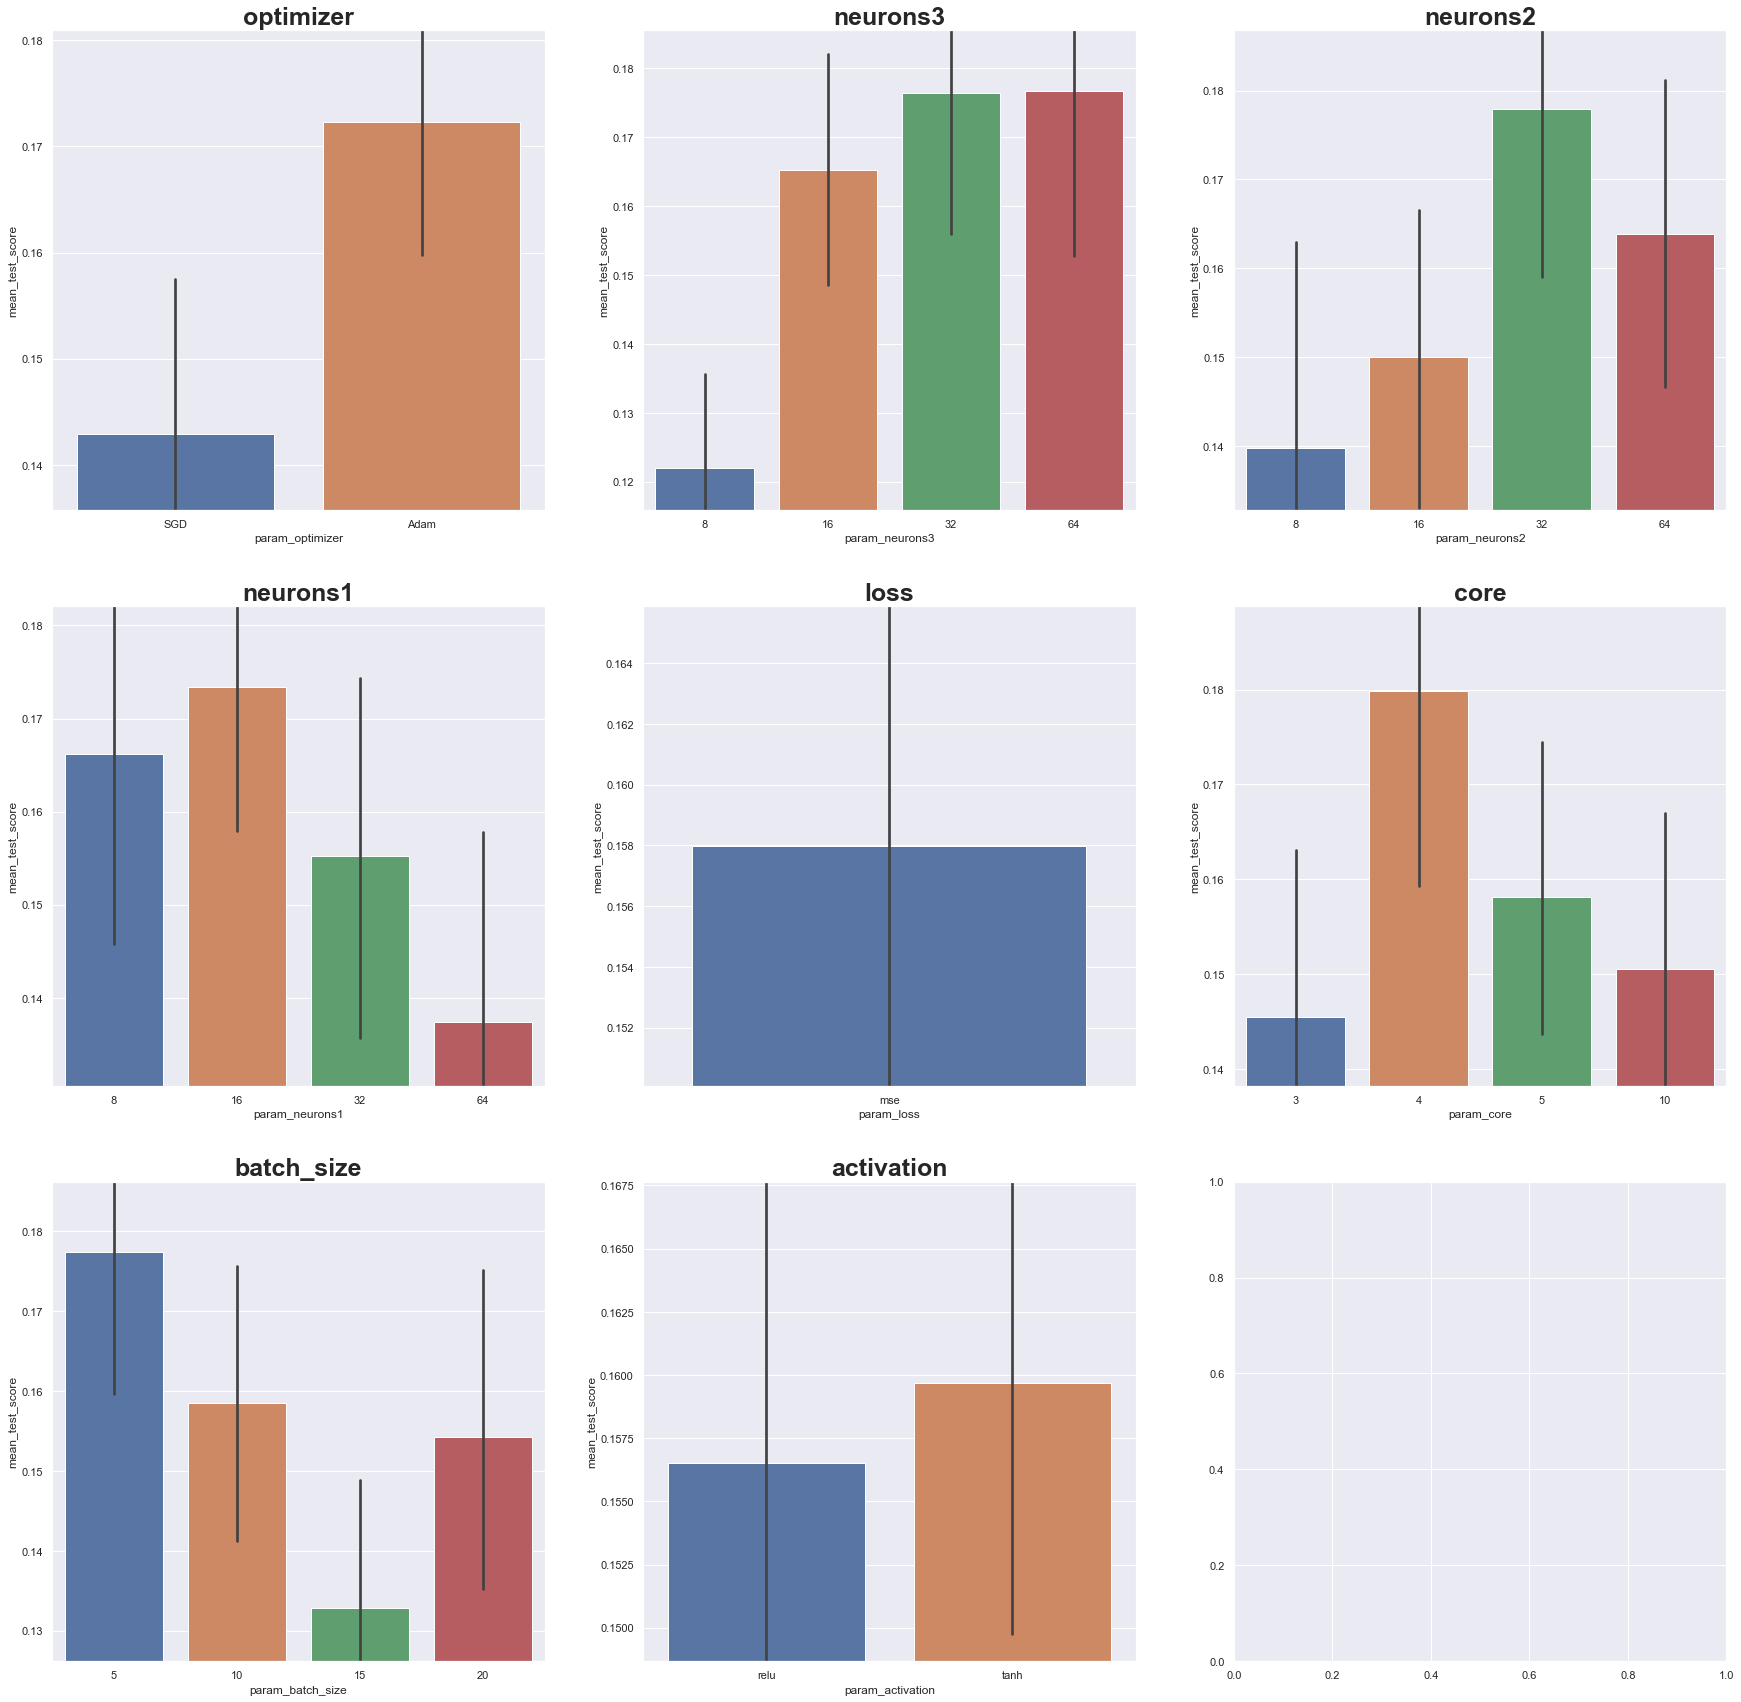

In [26]:
first_round_search(KerasClassifier(build_fn=create_model_conv), param_grid_conv, 300)

In [36]:
neurons1 = [i for i in range(12, 25, 2)]
neurons2 = [i for i in range(25, 40, 2)]
neurons3 = [i for i in range(25, 80, 4)]
core = [4,]
activation = ['tanh',]
optimizer = ['Adam',]
loss = ['mse']
batch_size= [5,]

param_grid_conv = dict(neurons1=neurons1, 
                  neurons2=neurons2, 
                  neurons3=neurons3,
                  core=core,
                  activation=activation, 
                  optimizer=optimizer,
                  loss=loss,
                  batch_size=batch_size)
param_grid_conv

{'neurons1': [12, 14, 16, 18, 20, 22, 24],
 'neurons2': [25, 27, 29, 31, 33, 35, 37, 39],
 'neurons3': [25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77],
 'core': [4],
 'activation': ['tanh'],
 'optimizer': ['Adam'],
 'loss': ['mse'],
 'batch_size': [5]}

In [37]:
early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=5)
grid_conv = GridSearchCV(estimator=model_conv,
                               param_grid=param_grid_conv,
                               scoring=scorer,
                               verbose=1,
                               cv=5,
                               n_jobs=-1)
grid_result_conv = grid_conv.fit(train_x3, train_y2, callbacks=[early_stopping], epochs=200)

Fitting 5 folds for each of 784 candidates, totalling 3920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 67.8min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 101.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 141.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 189.7min
[Parallel(n_jobs=-1)]: Done 3920 out of 3920 | elapsed: 240.1min finished


Epoch 1/200
186/186 [==============================] - 1s 3ms/step - loss: 0.2653 - categorical_accuracy: 0.3330
Epoch 2/200
186/186 [==============================] - 0s 3ms/step - loss: 0.2305 - categorical_accuracy: 0.3545
Epoch 3/200
186/186 [==============================] - 0s 3ms/step - loss: 0.2275 - categorical_accuracy: 0.3858
Epoch 4/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2282 - categorical_accuracy: 0.3761
Epoch 5/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2316 - categorical_accuracy: 0.3599
Epoch 6/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2220 - categorical_accuracy: 0.4149
Epoch 7/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2220 - categorical_accuracy: 0.4009
Epoch 8/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2245 - categorical_accuracy: 0.3750
Epoch 9/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2190 - categorical_

In [42]:
print("Best: %f using %s" % (grid_result_conv.best_score_, grid_result_conv.best_params_))

Best: 0.433264 using {'activation': 'tanh', 'batch_size': 5, 'core': 4, 'loss': 'mse', 'neurons1': 20, 'neurons2': 39, 'neurons3': 61, 'optimizer': 'Adam'}


In [43]:
pred_y = grid_result_conv.best_estimator_.predict(test_x3)

In [44]:
pred_y = [np.argmax(y) for y in pred_y]
pred_y = np.array(pred_y)
confusion_matrix(test_y, pred_y)

array([[ 84,   0,   0],
       [541,   0,   0],
       [ 63,   0,   0]], dtype=int64)

In [45]:
accuracy_score(test_y, pred_y)

0.12209302325581395

## Попробуем обучить модели на сгенерированных данных

In [2]:
df_gen = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\generated_data.csv', index_col='idx')
df_gen.drop(['text',],  inplace=True, axis=1)
df_gen.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_pres_sing,num_pres_plur,num_past_part,num_past_simple,num_linkings,num_4grams,num_func_ngrams,million_mistake,sum_punct,cls
idx,,,,,,,,,,,,,,,,,,,,,
0,3.69,7,2,2,2,0,13,189,4.23,14.54,...,7,0,2,4,6,3,1,0,0,4
1,3.93,7,2,1,3,1,15,244,4.80,16.27,...,14,0,3,0,13,2,0,0,0,4


In [3]:
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 0 to 9099
Data columns (total 67 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   av_depth            9100 non-null   float64
 1   max_depth           9100 non-null   int64  
 2   min_depth           9100 non-null   int64  
 3   num_acl             9100 non-null   int64  
 4   num_rel_cl          9100 non-null   int64  
 5   num_advcl           9100 non-null   int64  
 6   num_sent            9100 non-null   int64  
 7   num_tok             9100 non-null   int64  
 8   av_tok_before_root  9100 non-null   float64
 9   av_len_sent         9100 non-null   float64
 10  num_cl              9100 non-null   int64  
 11  num_tu              9100 non-null   int64  
 12  num_compl_tu        9100 non-null   int64  
 13  num_coord           9100 non-null   int64  
 14  num_poss            9100 non-null   int64  
 15  num_prep            9100 non-null   int64  
 16  num_ad

In [4]:
df_gen['cls'].value_counts()

5    2441
4    2386
3    2257
2    2016
Name: cls, dtype: int64

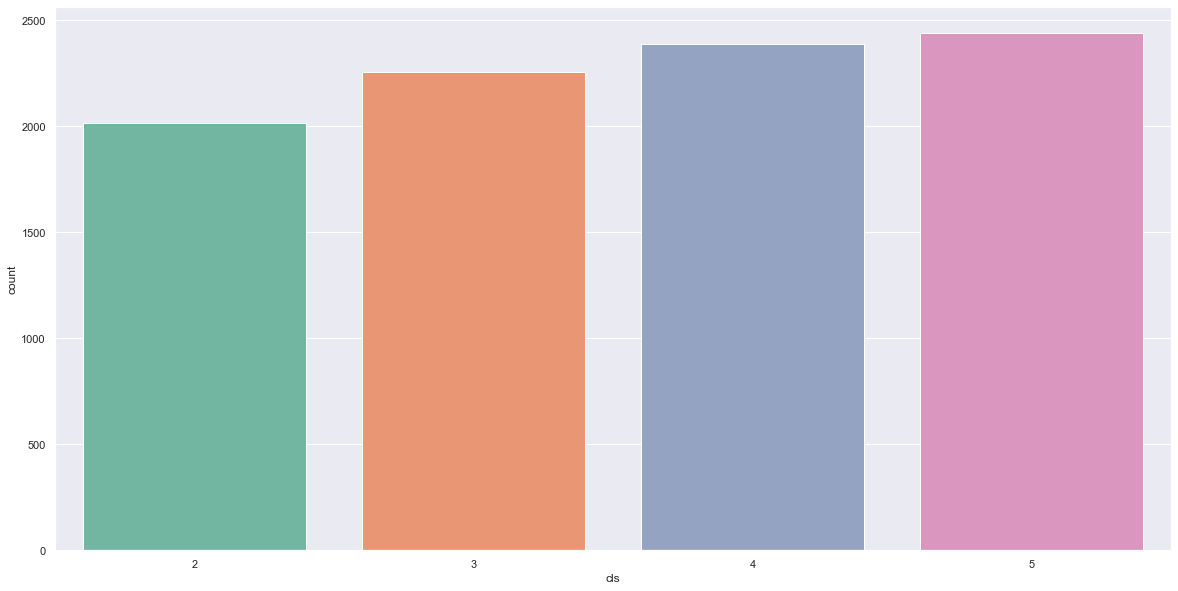

In [5]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='cls', data=df_gen, palette="Set2")

Т.к. сгенерированны данные только для тренировочной выборки, то тестовую выборку получим из начальных данных

In [6]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df.drop(['num_misspelled_tokens', 'num_shell_noun', 'name', 'type', 'punct_mistakes_pp', 'punct_mistakes_because', 'punct_mistakes_but', 'punct_mistakes_compare', 'side_mistake', 'text'],  inplace=True, axis=1)
df['class'] = round(df['class'] / 10).astype(int)
df.loc[df['class'] == 1, 'class'] = 2
df.loc[df['class'] == 3, 'class'] = 2
df.loc[df['class'] == 4, 'class'] = 3
df.loc[df['class'] == 5, 'class'] = 3
df.loc[df['class'] == 6, 'class'] = 4
df.loc[df['class'] == 7, 'class'] = 4
df.loc[df['class'] == 8, 'class'] = 5

df = df.rename(columns = {'class': 'cls'})
feature_columns = [col for col in df.columns if col not in ['cls',]]
X = df[feature_columns]
y = df['cls']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

In [7]:
feature_columns = [col for col in df_gen.columns if col not in ['cls',]]
train_x = df_gen[feature_columns]
train_y = df_gen['cls']